In [1]:
#Import modules and data
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report


Emo_Data_polarity=pd.read_csv('Emo_Data_polarity.csv')

print(Emo_Data_polarity.columns)
print('')
print(Emo_Data_polarity.shape)
print(Emo_Data_polarity.head())
print('')
Emo_Data_polarity.shape

Index(['Text', 'Emotion'], dtype='object')

(118961, 2)
                                                Text   Emotion
0                            i didnt feel humiliated  negative
1  i can go from feeling so hopeless to so damned...  negative
2   im grabbing a minute to post i feel greedy wrong  negative
3  i am ever feeling nostalgic about the fireplac...  positive
4                               i am feeling grouchy  negative



(118961, 2)

In [2]:
Emo_Data_polarity['Emotion'].unique()

array(['negative', 'positive', 'ambiguous', 'neutral'], dtype=object)

In [3]:
# Replacing intent text values to numerical
Emo_Data_polarity=Emo_Data_polarity.replace({"neutral":0,"negative":1,"positive":2, "ambiguous":3})
Emo_Data_polarity['Emotion'].unique()

array([1, 2, 3, 0])

In [4]:
# train, validation and test split dataset
x_train, x_test, y_train, y_test = train_test_split(Emo_Data_polarity["Text"], Emo_Data_polarity["Emotion"], test_size = 0.1, shuffle=True, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle=True, random_state = 1) 
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((96357,), (10707,), (11897,), (96357,), (10707,), (11897,))

In [5]:
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
print(stopwords.words('english'))
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stef_tse/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/stef_tse/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
def preprocess(text):
  text = nltk.word_tokenize(text.lower()) #lower case
  text = [w for w in text if not w in stop_words]
  text = (" ").join(text)
  text = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", text)
  text = re.sub(r"\s+", r" ", text).strip()
  text = re.sub(r'[^\w\s]', '', text)
  
  return text

x_train = x_train.apply(preprocess)
x_val =x_val.apply(preprocess)
x_test = x_test.apply(preprocess)

x_train.head()

86935    shows similar people kind situation demanding ...
10905                      feel took lot guts part admired
93263                 thank  thinking man never corrected 
35319    sarahstanley shudder thought thinking d d mana...
24972                                     living ignorance
Name: Text, dtype: object

In [7]:
word_to_counts = Counter(x_train)
word_to_counts

Counter({'': 70,
         'name ': 18,
         ' ': 17,
         'name': 17,
         'thank ': 16,
         'thanks': 13,
         'love': 13,
         'love ': 12,
         'thanks ': 11,
         'like ': 11,
         'happy cake day ': 10,
         'work': 9,
         'oh ': 8,
         'yes ': 8,
         'happy mothers day ': 8,
         'thank': 7,
         'fun ': 7,
         'oh name ': 7,
         'good': 7,
         'oh name': 7,
         'like': 6,
         'happy new year ': 6,
         'cute ': 6,
         'happy mother s day moms ': 6,
         'happy star wars day': 6,
         'thank  ': 6,
         'love name': 6,
         'bad day': 5,
         'name name': 5,
         'beautiful ': 5,
         'thank much': 5,
         'proud ': 5,
         'happy cake day': 5,
         'true': 5,
         'awesome ': 5,
         'like name': 5,
         'thank much ': 5,
         'true ': 5,
         'lol ': 5,
         'say ': 5,
         'tired ': 5,
         'name  ': 5,
      

In [8]:
# Get the number of unique words in the text data
n_words = len(word_to_counts)
n_words

95420

In [9]:
#create a word-to-index dictionary
tokenizer = Tokenizer(num_words=n_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

#convert the text data to numerical data
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [11]:
#Pad the sequences to have the same length
max_length = max([len(s) for s in x_train_seq + x_val_seq + x_test_seq])
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length)
x_train_pad.shape

(96357, 140)

In [12]:
#Define the number of unique classes
n_classes = len(np.unique(y_train))
n_classes

4

In [13]:
# Convert the class labels to one-hot encoded vectors
y_train_enc = tf.keras.utils.to_categorical(y_train, n_classes)
y_val_enc = tf.keras.utils.to_categorical(y_val, n_classes)
y_test_enc = tf.keras.utils.to_categorical(y_test, n_classes)
y_train_enc.shape

(96357, 4)

LSTM without pre-trained embeddings



In [14]:
# Define the LSTM model
model_01 = Sequential()
model_01.add(Embedding(input_dim=n_words, output_dim=64, input_length=max_length))
model_01.add(LSTM(64))
model_01.add(Dropout(0.5))
model_01.add(Dense(n_classes, activation='softmax'))
model_01.summary()

2024-01-18 13:44:32.480759: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-18 13:44:32.480802: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-18 13:44:32.480810: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-18 13:44:32.481319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-18 13:44:32.481776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 64)           6106880   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 6140164 (23.42 MB)
Trainable params: 6140164 (23.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
 # Compile and fit the model
model_01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_01.fit(x_train_pad, y_train_enc, batch_size=32, epochs=20, validation_data=(x_val_pad, y_val_enc))

Epoch 1/20


2024-01-18 14:10:17.140908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:10:17.245949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   1/3012 [..............................] - ETA: 37:02 - loss: 0.0617 - accuracy: 0.9688

2024-01-18 14:10:17.346334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3012/3012 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9358

2024-01-18 14:12:22.334655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:12:22.378957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3012/3012 [==============================] - 130s 43ms/step - loss: 0.1685 - accuracy: 0.9358 - val_loss: 2.2044 - val_accuracy: 0.5654
Epoch 2/20
3012/3012 [==============================] - 126s 42ms/step - loss: 0.1429 - accuracy: 0.9458 - val_loss: 2.4428 - val_accuracy: 0.5562
Epoch 3/20
3012/3012 [==============================] - 127s 42ms/step - loss: 0.1303 - accuracy: 0.9505 - val_loss: 2.4734 - val_accuracy: 0.5584
Epoch 4/20
3012/3012 [==============================] - 129s 43ms/step - loss: 0.1181 - accuracy: 0.9555 - val_loss: 2.6914 - val_accuracy: 0.5530
Epoch 5/20
3012/3012 [==============================] - 128s 43ms/step - loss: 0.1072 - accuracy: 0.9593 - val_loss: 2.9006 - val_accuracy: 0.5541
Epoch 6/20
3012/3012 [==============================] - 129s 43ms/step - loss: 0.0998 - accuracy: 0.9620 - val_loss: 2.8295 - val_accuracy: 0.5501
Epoch 7/20
3012/3012 [==============================] - 131s 43ms/step - loss: 0.0926 - accuracy: 0.9656 - val_loss: 2.9542 - val

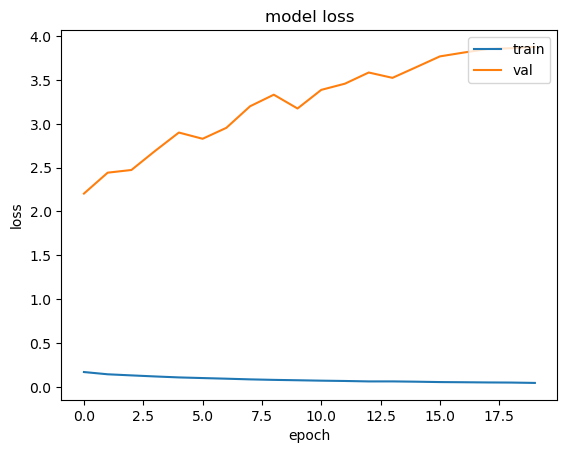

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

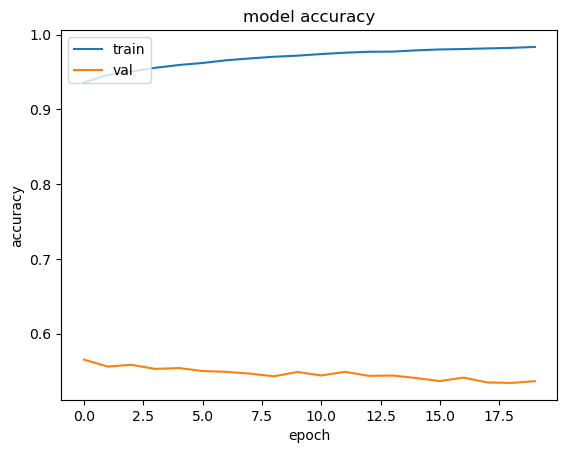

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
 # Evaluate the model on the test data
score, acc = model_01.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

372/372 [==============================] - 5s 14ms/step - loss: 3.9893 - accuracy: 0.5258
Test score: 3.9893312454223633
Test accuracy: 0.5257627964019775


In [20]:
# Generate the classification report
y_pred = model_01.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

  7/372 [..............................] - ETA: 3s  

2024-01-18 14:54:15.086398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:54:15.124185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


372/372 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.33      0.32      0.33      2429
           1       0.60      0.61      0.60      4135
           2       0.63      0.63      0.63      4373
           3       0.21      0.21      0.21       960

    accuracy                           0.53     11897
   macro avg       0.44      0.44      0.44     11897
weighted avg       0.52      0.53      0.52     11897



<Figure size 1000x1000 with 0 Axes>

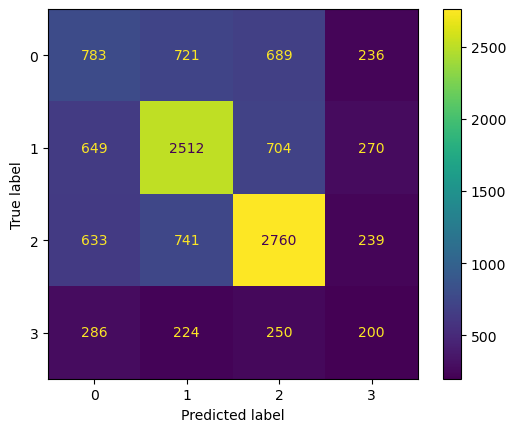

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

In [23]:
# Define LSTM model_02
from keras.layers import Flatten

model_02 = Sequential()
model_02.add(Embedding(input_dim=n_words, output_dim=64, input_length=max_length))
model_02.add(LSTM(64,return_sequences=True))
model_02.add(Dropout(0.5))
model_02.add(LSTM(64, return_sequences=True))
model_02.add(Dropout(0.5))
model_02.add(Flatten())
model_02.add(Dense(n_classes, activation='softmax'))
model_02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 64)           6106880   
                                                                 
 lstm_1 (LSTM)               (None, 140, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 140, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 140, 64)           33024     
                                                                 
 dropout_2 (Dropout)         (None, 140, 64)           0         
                                                                 
 flatten (Flatten)           (None, 8960)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                

In [24]:
# Compile and fit the model
model_02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_02.fit(x_train_pad, y_train_enc, batch_size=32, epochs=20, validation_data=(x_val_pad, y_val_enc))

Epoch 1/20


2024-01-18 14:55:28.520649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:55:28.694924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:55:28.763555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:55:29.065187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:55:29.183077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3012/3012 [==============================] - ETA: 0s - loss: 1.0057 - accuracy: 0.5805

2024-01-18 14:58:26.857731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:58:26.926262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 14:58:26.994741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3012/3012 [==============================] - 185s 61ms/step - loss: 1.0057 - accuracy: 0.5805 - val_loss: 0.9326 - val_accuracy: 0.6345
Epoch 2/20
3012/3012 [==============================] - 183s 61ms/step - loss: 0.8177 - accuracy: 0.6775 - val_loss: 0.9361 - val_accuracy: 0.6193
Epoch 3/20
3012/3012 [==============================] - 174s 58ms/step - loss: 0.6344 - accuracy: 0.7588 - val_loss: 1.0020 - val_accuracy: 0.6091
Epoch 4/20
3012/3012 [==============================] - 171s 57ms/step - loss: 0.4828 - accuracy: 0.8189 - val_loss: 1.2366 - val_accuracy: 0.5893
Epoch 5/20
3012/3012 [==============================] - 169s 56ms/step - loss: 0.3800 - accuracy: 0.8574 - val_loss: 1.3650 - val_accuracy: 0.5792
Epoch 6/20
3012/3012 [==============================] - 736s 244ms/step - loss: 0.3089 - accuracy: 0.8839 - val_loss: 1.5617 - val_accuracy: 0.5680
Epoch 7/20
3012/3012 [==============================] - 179s 60ms/step - loss: 0.2606 - accuracy: 0.9010 - val_loss: 1.8043 - va

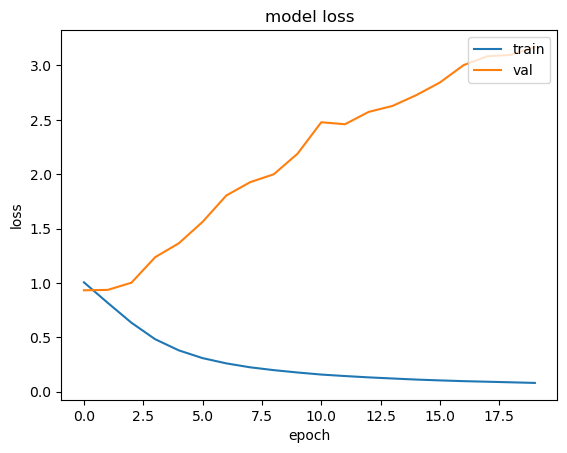

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

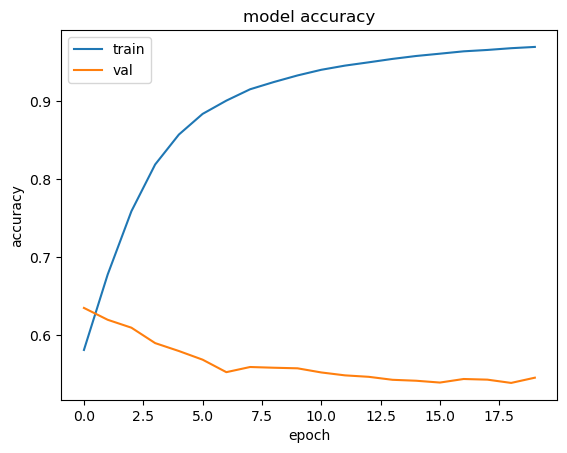

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Evaluate the model on the test data
score, acc = model_02.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

372/372 [==============================] - 6s 16ms/step - loss: 3.2057 - accuracy: 0.5384
Test score: 3.2057180404663086
Test accuracy: 0.5383710265159607


In [28]:
# Generate the classification report
y_pred = model_02.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

  1/372 [..............................] - ETA: 2:05

2024-01-18 20:15:25.094640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 20:15:25.153329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 20:15:25.220028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


372/372 [==============================] - 4s 9ms/step
              precision    recall  f1-score   support

           0       0.35      0.37      0.36      2429
           1       0.61      0.61      0.61      4135
           2       0.63      0.64      0.63      4373
           3       0.24      0.20      0.22       960

    accuracy                           0.54     11897
   macro avg       0.46      0.45      0.46     11897
weighted avg       0.54      0.54      0.54     11897



<Figure size 1000x1000 with 0 Axes>

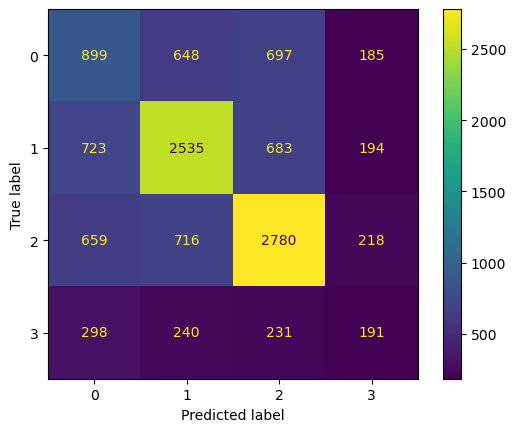

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

LSTM with Glove pre-trained word embeddings.

In [31]:
#Download Glove word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

zsh:1: command not found: wget
unzip:  cannot find or open glove.6B.zip, glove.6B.zip.zip or glove.6B.zip.ZIP.


In [32]:
#Create a dictionary with Glove embeddings
embeddings_index = {}
with open("/content/glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

FileNotFoundError: [Errno 2] No such file or directory: '/content/glove.6B.100d.txt'

In [ ]:
#Create embedding matrix. Words not found in embedding index will be all-zeros.
embedding_matrix = np.zeros((n_words, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#first LSTM model
model_03 = Sequential()
model_03.add(Embedding(input_dim=n_words, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_03.add(LSTM(64))
model_03.add(Dropout(0.5))
model_03.add(Dense(n_classes, activation='softmax'))
model_03.summary()

In [ ]:
# Compile and fit the model
model_03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_03.fit(x_train_pad, y_train_enc, batch_size=32, epochs=20, validation_data=(x_val_pad, y_val_enc))

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data
score, acc = model_03.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

In [ ]:
# Generate the classification report
y_pred = model_03.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()

In [ ]:
# Define the LSTM model_02
model_04 = Sequential()
model_04.add(Embedding(input_dim=n_words, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False,input_shape=(max_length,)))
model_04.add(LSTM(64,return_sequences=True))
model_04.add(Dropout(0.5))
model_04.add(LSTM(64, return_sequences=True))
model_04.add(Dropout(0.5))
model_04.add(Flatten())
model_04.add(Dense(n_classes, activation='softmax'))
model_04.summary()

In [ ]:
# Compile and fit the model
model_04.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_04.fit(x_train_pad, y_train_enc, batch_size=32, epochs=20, validation_data=(x_val_pad, y_val_enc))

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data
score, acc = model_04.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

In [ ]:
# Generate the classification report
y_pred = model_04.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4])
plt.figure(figsize=(10,10))
cm_display.plot()
plt.show()